# Data Cleaning

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Flatten

df = pd.read_csv('pakwheels.csv')

# Convert price, mileage, and engine_capacity to numeric after cleaning
df = df[df['price'] != 'Call for price']
# Drop rows where 'price' contains the string "Call for price"
# Drop rows where 'engine_capacity' contains the string ' kWh'
df = df[~df['engine_capacity'].str.contains(' kWh')]



df['price'] = df['price'].str.replace(',', '').str.replace('PKR', '')
df['price'] = df['price'].str.replace(' lacs', '').str.replace(' crore', '').astype(float)

df['mileage'] = df['mileage'].str.replace(',', '').str.replace(' km', '').astype(float)
df['engine_capacity'] = df['engine_capacity'].str.replace(' cc', '').astype(float)

# Handle missing values
df['model_year'].fillna(df['model_year'].median(), inplace=True)
df['engine_type'].fillna(df['engine_type'].mode()[0], inplace=True)
df['color'].fillna(df['color'].mode()[0], inplace=True)
df['body_type'].fillna(df['body_type'].mode()[0], inplace=True)
df['car_features'].fillna('Unknown', inplace=True)

# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in ['location', 'engine_type', 'transmission', 'registered_in', 'color', 'assembly', 'body_type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Drop unnecessary columns
df = df.drop(columns=['ad_url', 'title', 'ad_last_updated', 'description', 'car_features'])
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 0 to 6000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         5891 non-null   int64  
 1   model_year       5891 non-null   float64
 2   price            5891 non-null   float64
 3   mileage          5891 non-null   float64
 4   engine_type      5891 non-null   int64  
 5   transmission     5891 non-null   int64  
 6   registered_in    5891 non-null   int64  
 7   color            5891 non-null   int64  
 8   assembly         5891 non-null   int64  
 9   engine_capacity  5891 non-null   float64
 10  body_type        5891 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 552.3 KB
   location  model_year  price   mileage  engine_type  transmission  \
0       500      2007.0   16.5  100000.0            2             0   
1       310      2012.0    7.0  100000.0            2             1   
2       162      1995.0    7.6     

# Feature Engineering

In [14]:
# Extract car age from the model year
df['car_age'] = 2024 - df['model_year']

df.head()


,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,car_age
0,500,2007.0,16.5,100000.0,2,0,20,8,1,1800.0,13,17.0
1,310,2012.0,7.0,100000.0,2,1,8,8,1,800.0,6,12.0
2,162,1995.0,7.6,999.0,2,1,20,1,1,1500.0,13,29.0
3,554,2013.0,70.0,94000.0,2,0,20,1,1,2700.0,12,11.0
4,758,2015.0,8.0,86000.0,2,1,27,8,1,796.0,6,9.0


# Exploratory Data Analysis (EDA)

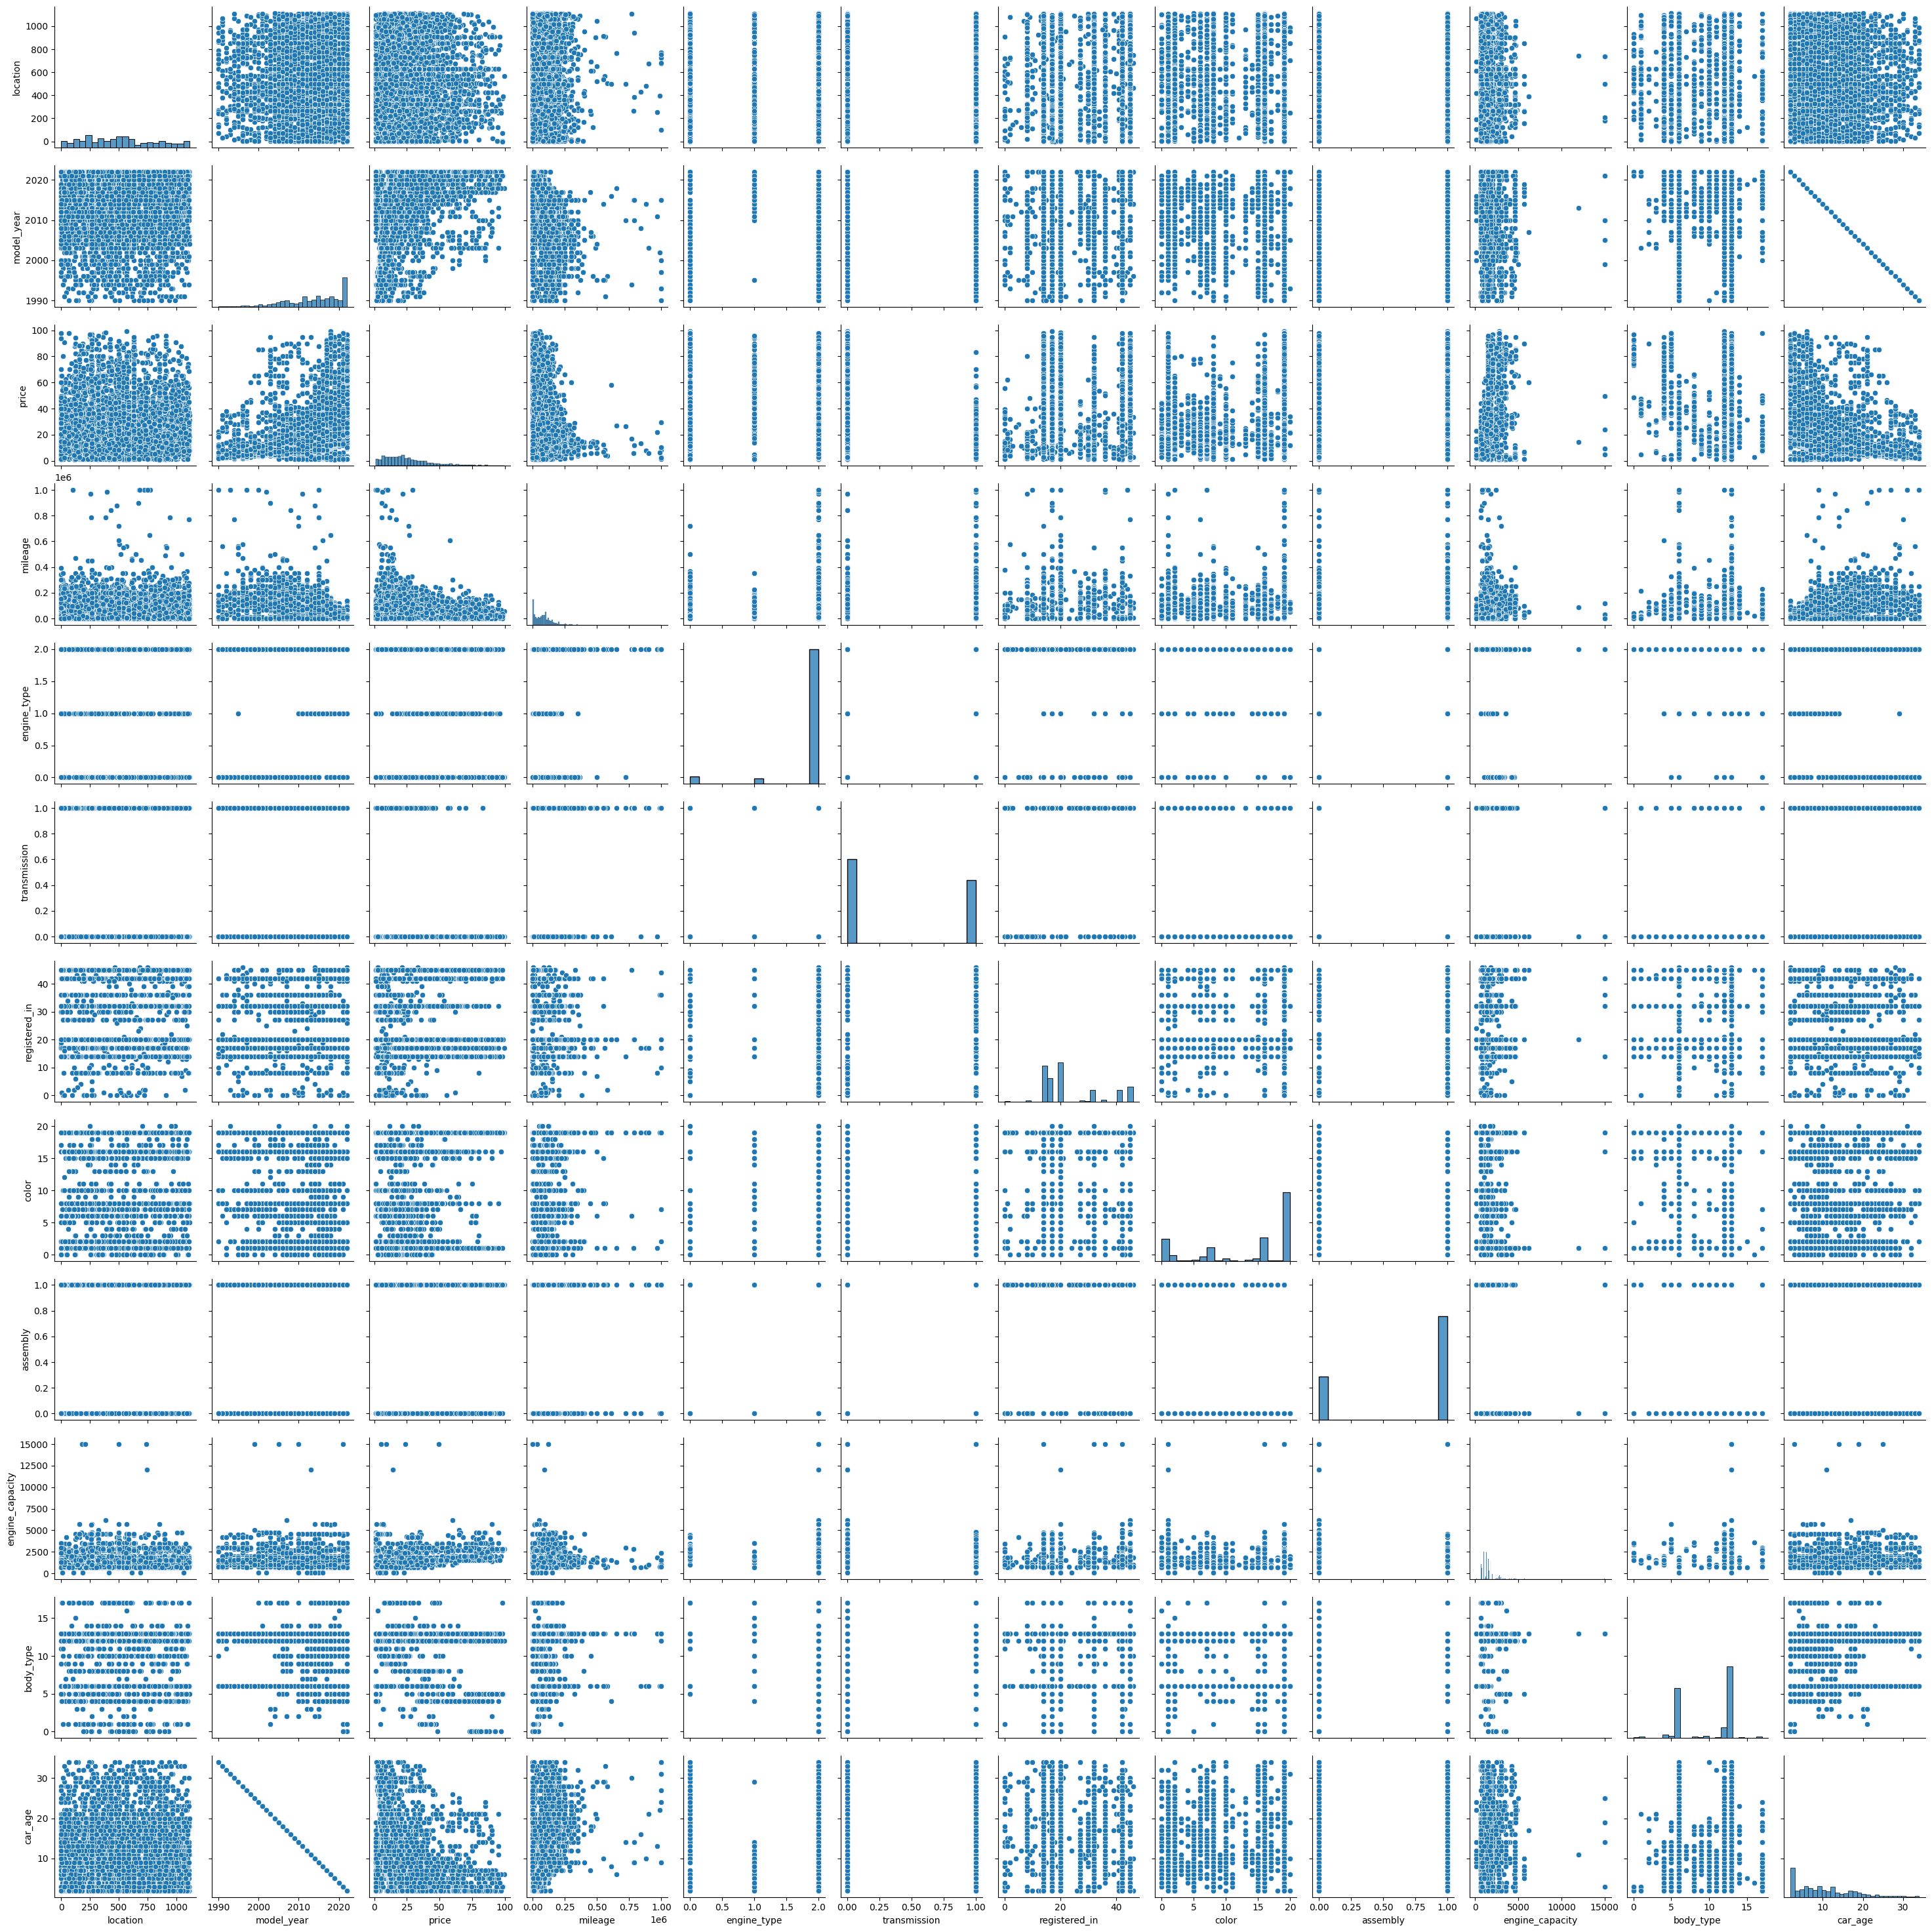

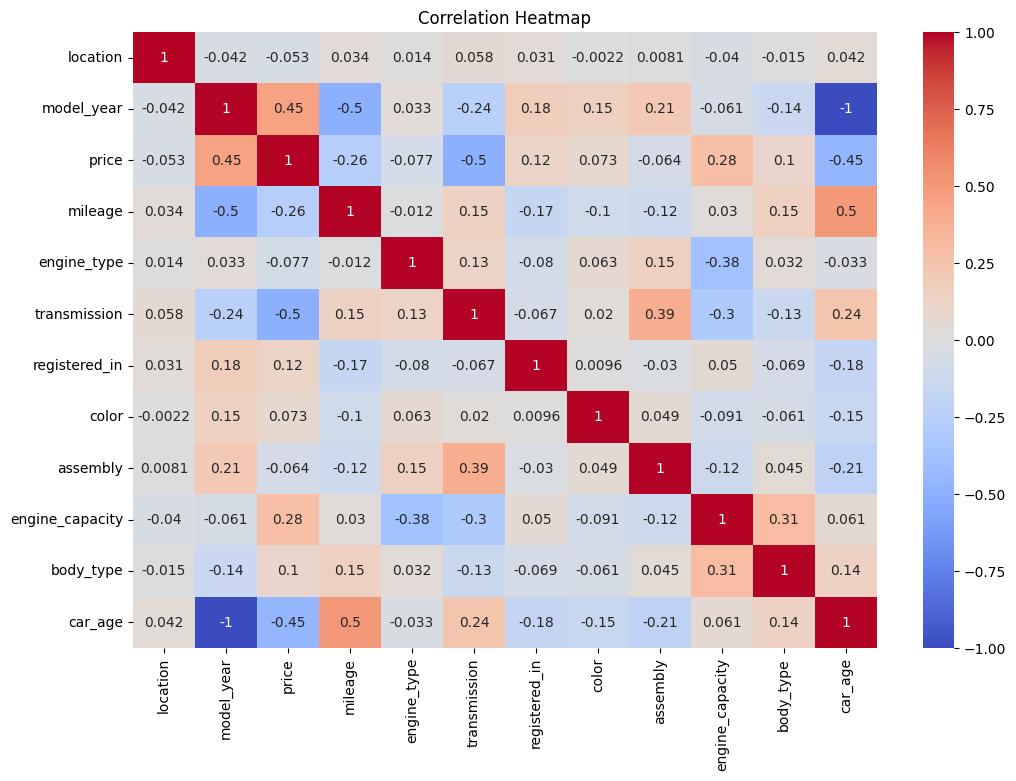

In [15]:
sns.pairplot(df)
plt.show()

# Correlation heatmap to visualize the correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**Strongest Relationships:**

**Car Age vs. Model Year:**
Correlation: -1

Summary: This is the strongest negative correlation, which is expected because as the car age increases, the model year decreases (older cars have earlier model years).

**Car Age vs. Mileage:**
Correlation: 0.5

Summary: Older cars tend to have higher mileage. This positive correlation indicates that as a car gets older, the distance it has traveled (mileage) generally increases.

**Model Year vs. Mileage:**

Correlation: -0.5

Summary: Newer cars tend to have lower mileage. This negative correlation suggests that the more recent the model year, the lower the car's mileage is likely to be.


**Moderate Relationships:**

**Price vs. Model Year:**

Correlation: 0.45

Summary: Newer cars generally have higher prices. The positive correlation indicates that cars from recent model years tend to be more expensive.

**Price vs. Engine Capacity:**

Correlation: 0.28

Summary: Cars with larger engines tend to be more expensive. This positive correlation suggests that engine capacity is a factor in determining the price of the car.

**Transmission vs. Engine Capacity:**

Correlation: 0.39

Summary: Certain transmission types might be associated with specific engine capacities. This positive correlation indicates that there is a relationship between the type of transmission and the engine capacity of the car.

**Engine Type vs. Engine Capacity:**

Correlation: -0.38

Summary: There is a negative correlation between engine type and engine capacity, suggesting that certain engine types are more likely to be associated with either smaller or larger engines.

# Data Splitting and Scaling

In [16]:
# Split the dataset into training and testing sets
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4712, 11)
Testing set shape: (1179, 11)


# Baseline Regressors

In [18]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("Gradient Boosting R2 Score:", r2_score(y_test, y_pred_gbr))

# Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("SVR R2 Score:", r2_score(y_test, y_pred_svr))

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree R2 Score:", r2_score(y_test, y_pred_dt))


Linear Regression RMSE: 14.935390496827845
Linear Regression R2 Score: 0.39139707547525593
Random Forest RMSE: 9.431700614398837
Random Forest R2 Score: 0.7572937923675727
Gradient Boosting RMSE: 10.939192120701236
Gradient Boosting R2 Score: 0.6735088825206743
SVR RMSE: 13.08045898531376
SVR R2 Score: 0.533182812602743
Decision Tree RMSE: 11.893353226714613
Decision Tree R2 Score: 0.6140691413822899


# Artificial Neural Network (ANN)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 365.1015 - val_loss: 216.3408
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 158.9804 - val_loss: 182.3399
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 145.0242 - val_loss: 168.3088
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 128.6705 - val_loss: 144.4107
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 114.1004 - val_loss: 151.0969
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 110.9922 - val_loss: 145.6574
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 116.4938 - val_loss: 137.0273
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111.1556 - val_loss: 153.9207
Epoch 9/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 100.4760 - val_loss: 150.7106
Epoch 10/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.4874 - val_loss: 138.8968


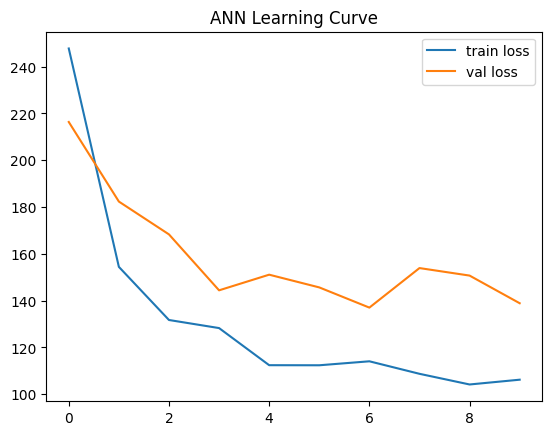

In [20]:
# Build the ANN model
ann = Sequential()
ann.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1))

# Compile the model
ann.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history_ann = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Plotting the learning curve for ANN
plt.plot(history_ann.history['loss'], label='train loss')
plt.plot(history_ann.history['val_loss'], label='val loss')
plt.legend()
plt.title('ANN Learning Curve')
plt.show()


# Key Observations:
**Training Loss:**

The blue line represents the training loss, which decreases steadily over the epochs. This suggests that the model is learning and improving its performance on the training data as it undergoes more epochs.

**Validation Loss:**
The orange line represents the validation loss. Initially, it decreases alongside the training loss, which is a good sign as it indicates that the model is generalizing well to unseen data.
However, starting around the 3rd or 4th epoch, the validation loss begins to fluctuate and doesn’t follow the same decreasing pattern as the training loss. This could indicate potential overfitting, where the model is starting to memorize the training data rather than learning to generalize from it.

**Final Loss Values:**
By the end of the 10th epoch, the training loss is low, indicating good performance on the training set. However, the validation loss does not decrease as much and remains relatively high, which could be a sign that the model's performance on unseen data is not as strong as on the training data.

# CNN

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 346.8046 - val_loss: 176.0345
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147.3224 - val_loss: 165.8777
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.3776 - val_loss: 156.1503
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 131.9684 - val_loss: 163.0143
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.9421 - val_loss: 165.5702
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 137.5939 - val_loss: 153.9658
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 112.6933 - val_loss: 139.6501
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.0364 - val_loss: 163.4439
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 95.6179 - val_loss: 160.6083
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 107.0999 - val_loss: 131.4849
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.1265 - val_loss: 136.8907
Epoch 12/50
148/148 ━

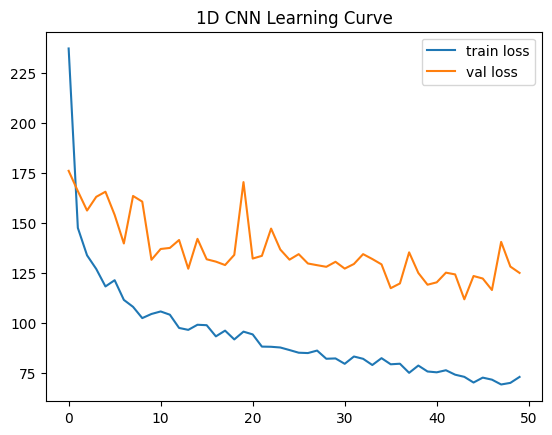

In [21]:
# Build the 1D CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(1))

# Compile the model
cnn.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Train the model
history_cnn = cnn.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=50, batch_size=32)

# Plotting the learning curve for CNN
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.legend()
plt.title('1D CNN Learning Curve')
plt.show()


# Key Observations:
**Training Loss (Blue Line):**

The training loss starts high and consistently decreases as training progresses.
This indicates that the model is learning to minimize the error on the training data over time, which is expected.

**Validation Loss (Orange Line):**

The validation loss also starts high and decreases initially, but it exhibits more fluctuations compared to the training loss.
There are points where the validation loss spikes, which suggests that the model may not be generalizing perfectly to the validation data. The spikes could be due to overfitting, where the model starts to learn the noise or specific patterns in the training data that don’t generalize well to unseen data.

# Detailed Explanation:
**Epochs 0-10:**

Both training and validation losses decrease significantly. This is a typical behavior at the beginning of training, as the model quickly learns the most prominent features of the data.

**Epochs 10-30:**

The training loss continues to decrease steadily, suggesting that the model is getting better at minimizing the error on the training data.
The validation loss, however, begins to fluctuate more. This could indicate the start of overfitting, where the model’s performance on unseen data (validation set) is not improving as consistently as it does on the training set.

**Epochs 30-50:**

The training loss continues to decrease, which is good, but the validation loss does not follow the same pattern. It fluctuates and even increases at some points, which further suggests that the model is starting to overfit the training data.